## Useful links
- vgg16 keras implementation - https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
- another vgg16 keras implementation - https://github.com/SamSamskies/courses/blob/master/deeplearning1/nbs/vgg16.py
- keras model API - https://keras.io/models/model/
- nvidia model implementation - https://github.com/jacobgil/keras-steering-angle-visualizations
- vehicle steering angle visualizations blog post - https://jacobgil.github.io/deeplearning/vehicle-steering-angle-visualizations
- comma ai - https://github.com/commaai/research/blob/master/train_steering_model.py

In [63]:
import os
import sys
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import json
from imp import reload
import utils; reload(utils)

IMAGE_SHAPE = (100, 320, 3)
DATA_PATH = '../data/'

def save_model(model, model_filename, weights_filename):
    if Path(model_filename).is_file():
        os.remove(model_filename)

    with open(model_filename,'w' ) as f:
        json.dump(model.to_json(), f)
        
    if Path(weights_filename).is_file():
        os.remove(weights_filename)
        
    model.save_weights(weights_filename)
    

def get_commaai_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=IMAGE_SHAPE))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode='same'))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
              
    return model

In [64]:
model = get_commaai_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_11 (Lambda)               (None, 100, 320, 3)   0           lambda_input_11[0][0]            
____________________________________________________________________________________________________
convolution2d_31 (Convolution2D) (None, 25, 80, 16)    3088        lambda_11[0][0]                  
____________________________________________________________________________________________________
elu_41 (ELU)                     (None, 25, 80, 16)    0           convolution2d_31[0][0]           
____________________________________________________________________________________________________
convolution2d_32 (Convolution2D) (None, 13, 40, 32)    12832       elu_41[0][0]                     
___________________________________________________________________________________________

,image,is_flipped,steering
0,IMG/left_2016_12_01_13_30_48_287.jpg,False,0.250000
1,IMG/center_2016_12_01_13_30_48_287.jpg,False,0.000000
2,IMG/right_2016_12_01_13_30_48_287.jpg,False,-0.250000
3,IMG/left_2016_12_01_13_30_48_404.jpg,False,0.250000
4,IMG/center_2016_12_01_13_30_48_404.jpg,False,0.000000
5,IMG/right_2016_12_01_13_30_48_404.jpg,False,-0.250000
6,IMG/left_2016_12_01_13_31_13_177.jpg,False,0.250000
7,IMG/center_2016_12_01_13_31_13_177.jpg,False,0.000000
8,IMG/right_2016_12_01_13_31_13_177.jpg,False,-0.250000
9,IMG/left_2016_12_01_13_32_43_053.jpg,False,0.250000


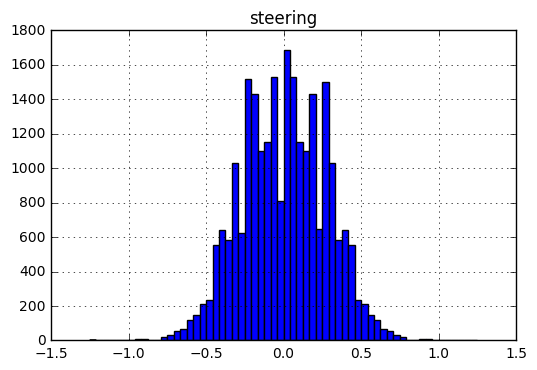

In [65]:
# TODO: 
# 1. Make utils file with dataframe augmentation functions and load image function
# 2. Load a small sample subset and train model and try running the simulation with it
# 3. Try to figure out how to make a generator to use with fit_generator
df = utils.augment_dataframe(pd.read_csv(DATA_PATH + 'driving_log.csv'))
df.hist(column='steering', bins=60)
df.head(20)

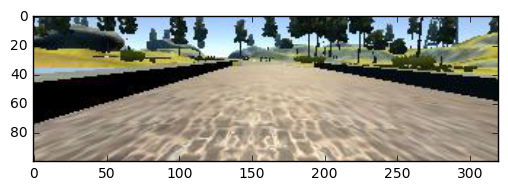

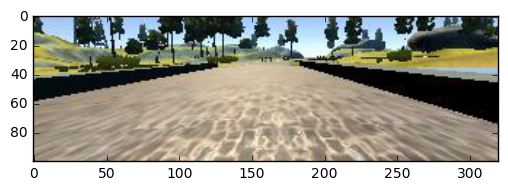

In [66]:
row = df.iloc[0]
image_path = DATA_PATH + row.image.strip()
test = utils.load_image(image_path, row.is_flipped)
plt.imshow(test)
plt.figure()
test = utils.load_image(image_path, True)
plt.imshow(test)

In [70]:
# try sample of 100 images
df_sample = df.sample(100)
train_features = []
train_labels = []

for _, row in df_sample.iterrows():
    image_path = DATA_PATH + row.image.strip()
    train_features.append(utils.load_image(image_path, row.is_flipped))
    train_labels.append(row.steering)

model.fit(np.array(train_features), np.array(train_labels), batch_size=10, nb_epoch=100, validation_split=0.2)
save_model(model, '../model.json', '../model.h5')

Train on 80 samples, validate on 20 samples
Epoch 1/100
80/80 [==============================] - 0s - loss: 0.1010 - val_loss: 0.1110
Epoch 2/100
80/80 [==============================] - 0s - loss: 0.0494 - val_loss: 0.1010
Epoch 3/100
80/80 [==============================] - 0s - loss: 0.0216 - val_loss: 0.0979
Epoch 4/100
80/80 [==============================] - 0s - loss: 0.0197 - val_loss: 0.0962
Epoch 5/100
80/80 [==============================] - 0s - loss: 0.0126 - val_loss: 0.1035
Epoch 6/100
80/80 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0984
Epoch 7/100
80/80 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0933
Epoch 8/100
80/80 [==============================] - 0s - loss: 0.0151 - val_loss: 0.0966
Epoch 9/100
80/80 [==============================] - 0s - loss: 0.0109 - val_loss: 0.0871
Epoch 10/100
80/80 [==============================] - 0s - loss: 0.0139 - val_loss: 0.0938
Epoch 11/100
80/80 [==============================] - 0

In [ ]:
# try loading model into simulator